# Facial Emotion Recognition

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Unzipping the dataset

In [ ]:
import os
import zipfile
path_to_zip_file='/content/gdrive/MyDrive/emotiondataset.zip'
directory_to_extract_to='/content/gdrive/MyDrive/Emotions/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


### Importing necessary libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, MaxPool2D, AveragePooling2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical
from PIL import Image

### Preprocessing the dataset

In [ ]:
# creating dictionaries to map the labels with class values

emotion_label_to_text = {0:'happy', 1:'sad', 2: 'surprise', 3: 'fear', 4: 'disgust', 5: 'anger'}
emotion_text_to_label = {'happy':0, 'sad':1,'surprise':2, 'fear':3,  'disgust':4, 'anger':5}

In [ ]:
# specifying path of source and destination folders

train_src = "/content/gdrive/MyDrive/Emotions/train_class/"
train_des = "/content/gdrive/MyDrive/Emotions/train_dest/"
val_src = "/content/gdrive/MyDrive/Emotions/val_class/"
val_des = "/content/gdrive/MyDrive/Emotions/val_dest/"

# making destination folders
os.mkdir(train_des)
os.mkdir(val_des)
folders = ["class001","class002","class003","class004","class005","class006","class007","class008"]

In [ ]:
# taking from source, resizing and storing in the destination folder training data

checks = []
checksn = []
c = 1
for folder in folders:
  directory = train_src + folder + '/'
  new_dir = train_des + emotion_label_to_text[c]
  os.mkdir(new_dir)
  new_dir = new_dir + '/'
  c+=1
  i = 0
  for f in os.listdir(directory):
    image = os.path.join(directory, f)
    des_image = os.path.join(new_dir, f)
    img_ = img_to_array(load_img(image, target_size=(224,224)))
    save_img(des_image, img_)
    if(i == 0):
      img = Image.open(image)
      # pyplot.imshow(img)
      i = 1
      checks.append(image)
      checksn.append(des_image)

In [ ]:
# taking from source, resizing and storing in the destination folder validation data

checkv = []
checkvn = []
c = 1
for folder in folders:
  directory = val_src + folder + '/'
  new_dir = val_des + emotion_label_to_text[c]
  os.mkdir(new_dir)
  new_dir = new_dir + '/'
  c+=1
  i = 0
  for f in os.listdir(directory):
    image = os.path.join(directory, f)
    des_image = os.path.join(new_dir, f)
    img_ = img_to_array(load_img(image, target_size=(224,224)))
    save_img(des_image, img_)
    if(i == 0):
      img = Image.open(image)
      i = 1
      checks.append(image)
      checksn.append(des_image)

### Making usable dataset

In [ ]:
# function to create tensor dataset from training images 
# Here I have used 3000 samples per class instead of entire dataset due to memory constraints 

def create_dataset_tf(img_folder):
    class_name=[]
    tf_img_data_array=[]   

    fig = pyplot.figure()
    rows = 4
    columns = 2
    
    for dir1 in os.listdir(img_folder):
        if (dir1 == 'neutral' or dir1 = 'contempt'):
            continue
        c = 0
        i = 1
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image= os.path.join(img_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=1)
            image = tf.cast(tf.cast(image,tf.float32) / 255., tf.float16)
            image = np.array(image)
            tf_img_data_array.append(image)
            class_name.append(emotion_text_to_label[dir1])              
            c+=1
            if(c == 3000):
              break     
    return tf.stack(tf_img_data_array, axis=0),class_name

In [ ]:
# function to create tensor dataset from validation images 

def create_valdataset_tf(img_folder):
    class_name=[]
    tf_img_data_array=[]   
    
    for dir1 in os.listdir(img_folder):
        if (dir1 == 'neutral' or dir1 = 'contempt'):
            continue
        c = 0
        i = 1
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image= os.path.join(img_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=1)
            image = tf.cast(tf.cast(image,tf.float32) / 255., tf.float16)
            image = np.array(image)
            tf_img_data_array.append(image)
            class_name.append(emotion_text_to_label[dir1])              
        
    return tf.stack(tf_img_data_array, axis=0),class_name

In [ ]:
img_data, classname = create_dataset_tf(train_des)

In [ ]:
val_data, valclass = create_valdataset_tf(val_des)

In [ ]:
# categorizing training labels

y_label = to_categorical(classname)

In [ ]:
# categorizing validation labels

val_y = to_categorical(valclass)

### Converting to numpy array and saving for reusability

In [ ]:
out_train = np.asarray(img_data)

In [ ]:
out_val = np.asarray(val_data)
out_val_label = np.asarray(val_y)

In [ ]:
out_train_label = np.asarray(y_label)


In [ ]:
np.save('/content/gdrive/MyDrive/val224_1k.npy',out_val)
np.save('/content/gdrive/MyDrive/val224_1k_label.npy',out_val_label)


In [ ]:
np.save('/content/gdrive/MyDrive/train224_16k.npy',out_train)

np.save('/content/gdrive/MyDrive/train224_16k_label.npy',out_train_label)

### Leading the dataset

In [ ]:
x_val = np.load('/content/gdrive/MyDrive/Copy of 6classval224_full.npy')
y_val = np.load('/content/gdrive/MyDrive/Copy of 6classval224_full_label.npy')

In [ ]:
x_train = np.load('/content/gdrive/MyDrive/Copy of 6classtrain224_18k.npy')
y_train = np.load('/content/gdrive/MyDrive/Copy of 6classtrain224_18k_label.npy')

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(18000, 224, 224, 1)
(18000, 6)
(3000, 224, 224, 1)
(3000, 6)


## Training

In [ ]:
#callbacks
check_pointer = ModelCheckpoint(filepath='/content/gdrive/MyDrive/check6cmobilenew.h5',save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',patience=20,min_delta=0,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1)

### Own Custom CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

In [ ]:
# with tf.device('/device:GPU:0'):
model.compile(optimizer='adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

In [ ]:
history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=200, callbacks=[early_stop, check_pointer, reduce_lr])

### Final Validation Accuracy on Own Custom CNN is 44.67%

### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

model_res50 = ResNet50()

z = model_res50.layers[-1].output
output = Dense(6,activation = 'softmax')(z)
model_res50 = Model(inputs = model_res50.input, outputs = output)
model_res50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
input = Input(shape=(224,224,1), name='img_input')
x = Conv2D(3,(3,3),padding='same')(input) 
z = model_res50(x)
model_r = Model(inputs= input, outputs= z)
model_r.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 model (Functional)          (None, 6)                 25642718  
                                                                 
Total params: 25,642,748
Trainable params: 25,589,628
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_r.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_r.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=100, callbacks=[early_stop, check_pointer, reduce_lr])

Epoch 1/100
563/563 [==============================] - ETA: 0s - loss: 1.7916 - accuracy: 0.1681

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


563/563 [==============================] - 208s 339ms/step - loss: 1.7916 - accuracy: 0.1681 - val_loss: 1.7919 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 190s 338ms/step - loss: 1.7874 - accuracy: 0.1827 - val_loss: 1.7925 - val_accuracy: 0.1743 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 195s 347ms/step - loss: 1.7867 - accuracy: 0.1910 - val_loss: 1.7808 - val_accuracy: 0.1983 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 196s 348ms/step - loss: 1.7723 - accuracy: 0.2101 - val_loss: 1.7666 - val_accuracy: 0.2183 - lr: 0.0010
Epoch 5/100
563/563 [==============================] - 192s 340ms/step - loss: 1.7535 - accuracy: 0.2269 - val_loss: 1.8165 - val_accuracy: 0.1727 - lr: 0.0010
Epoch 6/100
563/563 [==============================] - 191s 340ms/step - loss: 1.7154 - accuracy: 0.2560 - val_loss: 1.8122 - val_accuracy: 0.1943 - lr: 0.0010
Epoch 7/100
563/563 [==============================]

### Final best validation accuracy on ResNet50 is 53.50%

### MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet

model_mobile = MobileNet()

z = model_mobile.layers[-1].output
output = Dense(6,activation = 'softmax')(z)
model_mobile = Model(inputs = model_mobile.input, outputs = output)
model_mobile.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [ ]:
input = Input(shape=(224,224,1), name='img_input')
x = Conv2D(3,(3,3),padding='same')(input) 
z = model_mobile(x)
model_m = Model(inputs= input, outputs= z)
model_m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 model (Functional)          (None, 6)                 4259870   
                                                                 
Total params: 4,259,900
Trainable params: 4,238,012
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
model_m.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_m.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=100, callbacks=[early_stop, check_pointer, reduce_lr])

Epoch 1/100
563/563 [==============================] - 211s 348ms/step - loss: 1.7156 - accuracy: 0.3056 - val_loss: 1.7390 - val_accuracy: 0.2460 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 190s 338ms/step - loss: 1.6333 - accuracy: 0.3358 - val_loss: 1.6997 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 190s 338ms/step - loss: 1.5706 - accuracy: 0.3574 - val_loss: 1.5382 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 188s 334ms/step - loss: 1.5364 - accuracy: 0.3641 - val_loss: 1.5645 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 5/100
563/563 [==============================] - 190s 338ms/step - loss: 1.4970 - accuracy: 0.3748 - val_loss: 1.5035 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 6/100
563/563 [==============================] - 190s 338ms/step - loss: 1.4507 - accuracy: 0.3964 - val_loss: 1.4668 - val_accuracy: 0.3720 - lr: 0.0010
Epoch 7/100
563/563 [===================

### Final Validation accuracy on MobileNet is 57.43%

## Loading model and making predictions

In [ ]:
final_model = load_model('/content/gdrive/MyDrive/check6cmobilenew.h5')

In [ ]:
y_pred = final_model.predict(x_val)

In [ ]:
# checking the confusion matrix
conf_mat = np.zeros((6,6))
for i in range(len(y_val)):
    conf_mat[np.argmax(y_val[i])][np.argmax(y_pred[i])] += 1 

In [ ]:
print(conf_mat)

[[389.  37.  48.   4.  14.   8.]
 [ 19. 291.  30.  60.  29.  71.]
 [ 25.  65. 157. 222.  19.  12.]
 [  9.  75.  60. 316.  17.  23.]
 [ 28. 103.  38.  29.  75. 227.]
 [ 17.  93.  29.  41.  58. 262.]]


In [ ]:
y_pred_class = [emotion_label_to_text[np.argmax(i)] for i in y_pred ]
y_label_class = [emotion_label_to_text[np.argmax(i)] for i in y_val ]

Actual label: happy 
Predicted label: happy


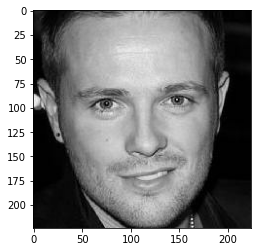

In [ ]:
xn = np.array(x_val[100], dtype=np.float64) #we need to convert the data type to float64 ans float16 is not supported by plotly
pyplot.imshow(xn[:,:,0], cmap = 'gray')
print("Actual label:",y_label_class[100],"\nPredicted label:",y_pred_class[100])

Actual label: happy 
Predicted label: happy


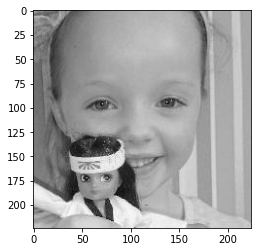

In [ ]:
xn = np.array(x_val[233], dtype=np.float64)
pyplot.imshow(xn[:,:,0], cmap = 'gray')
print("Actual label:",y_label_class[233],"\nPredicted label:",y_pred_class[233])

Actual label: surprise 
Predicted label: surprise


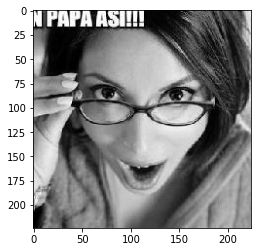

In [ ]:
xn = np.array(x_val[1006], dtype=np.float64)
pyplot.imshow(xn[:,:,0], cmap = 'gray')
print("Actual label:",y_label_class[1006],"\nPredicted label:",y_pred_class[1006])